In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [15]:
image_width = 224
image_height = 224
batch_size = 32
num_classes = 21
epochs = 10

In [18]:
train_data_dir = 'train_path'
val_data_dir = 'validation_path'
test_data_dir = 'test_path'

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(image_width, image_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_data_dir,
                                                target_size=(image_width, image_height),
                                                batch_size=batch_size,
                                                class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(image_width, image_height),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


In [20]:
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [21]:
for layer in base_model.layers:
    layer.trainable = False

In [23]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
history=model.fit(train_generator,
          steps_per_epoch=train_generator.n // batch_size,
          epochs=epochs,
          validation_data=val_generator,
          validation_steps=val_generator.n // batch_size)

Epoch 1/10
229/229 [==============================] - 416s 2s/step - loss: 0.5409 - accuracy: 0.8414 - val_loss: 0.4055 - val_accuracy: 0.8784
Epoch 2/10
229/229 [==============================] - 310s 1s/step - loss: 0.3692 - accuracy: 0.8875 - val_loss: 0.3556 - val_accuracy: 0.8856
Epoch 3/10
229/229 [==============================] - 314s 1s/step - loss: 0.3083 - accuracy: 0.9042 - val_loss: 0.3145 - val_accuracy: 0.8933
Epoch 4/10
229/229 [==============================] - 316s 1s/step - loss: 0.2588 - accuracy: 0.9212 - val_loss: 0.2809 - val_accuracy: 0.9000
Epoch 5/10
229/229 [==============================] - 312s 1s/step - loss: 0.2305 - accuracy: 0.9298 - val_loss: 0.2478 - val_accuracy: 0.9212
Epoch 6/10
229/229 [==============================] - 313s 1s/step - loss: 0.2205 - accuracy: 0.9298 - val_loss: 0.2484 - val_accuracy: 0.9163
Epoch 7/10
229/229 [==============================] - 314s 1s/step - loss: 0.2034 - accuracy: 0.9351 - val_loss: 0.2278 - val_accuracy: 0.9260

In [26]:
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

class_report = classification_report(y_true, y_pred)

In [27]:
print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("\nClassification Report:\n", class_report)

Accuracy: 0.92
F1 Score: 0.92
Precision: 0.92
Recall: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        50
           1       1.00      0.94      0.97        50
           2       0.90      0.94      0.92        50
           3       0.98      0.98      0.98        50
           4       0.81      0.92      0.86        50
           5       1.00      1.00      1.00        50
           6       0.73      0.74      0.73        50
           7       0.98      0.96      0.97        50
           8       0.88      0.98      0.92        50
           9       0.95      0.84      0.89        50
          10       0.96      0.98      0.97        50
          11       0.96      0.92      0.94        50
          12       0.88      0.72      0.79        50
          13       0.85      0.90      0.87        50
          14       0.98      0.84      0.90        50
          15       0.98      0.96      0.97        

In [28]:
class_names = list(train_generator.class_indices.keys())

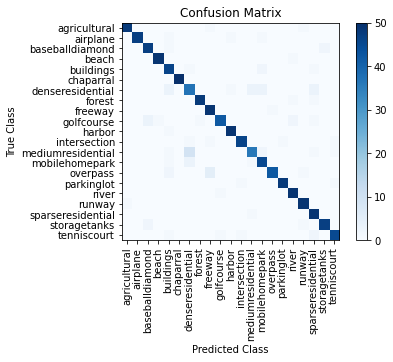

In [29]:
confusion_matrix = np.zeros((num_classes, num_classes))
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1

plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


In [36]:
sample_image_path = '/test.png'
sample_image = load_img(sample_image_path, target_size=(image_width, image_height))
sample_image_array = img_to_array(sample_image)
sample_image_array = np.expand_dims(sample_image_array, axis=0)
sample_image_array = sample_image_array / 255.0

predicted_class_idx = np.argmax(model.predict(sample_image_array), axis=1)
predicted_class = class_names[predicted_class_idx[0]]
print("Predicted class for the sample image:", predicted_class)

Predicted class for the sample image: denseresidential


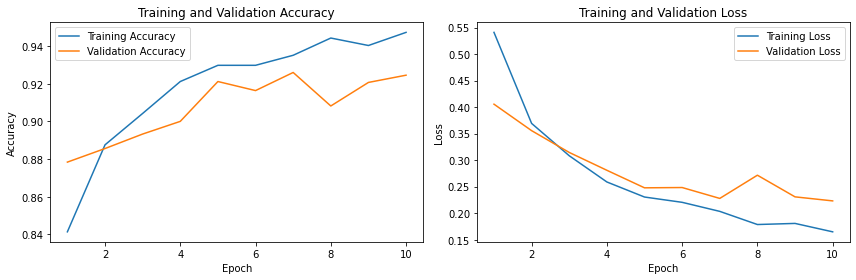

In [37]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
model.save('InceptionV3.h5')